#   Procesamiento del lenguaje natural. Anàlisis de sentimientos

In [1]:
import pandas as pd 
import scipy as scy
import nltk
import sklearn 
import collections 
import string 
import csv
from pandas import read_csv
import seaborn as sns
import string
import re

In [ ]:
workdir= '/home/juanfi/Documentos/diplo_utn/clases/6-Procesamiento del lenguaje natural/works/YELP/yelp_dataset/'

In [5]:
!ls 

data_tp6.csv  sample_data


In [6]:
! head -n 1 yelp_academic_dataset_review.json

head: cannot open 'yelp_academic_dataset_review.json' for reading: No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
size = 100000
review = pd.read_json('yelp_academic_dataset_review.json', lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,'useful':int,
                             'funny':int,'cool':int,'text':str,
                             'date':str},
                      chunksize=size)

In [ ]:
## El siguiente codigo lee el data set en porciones 


# There are multiple chunks to be read
chunk_list = []
for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    # Show feedback on progress
    print(f"{chunk_review.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_review)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
100000 out of 100,000 related reviews
69264 out of 100,000 related reviews


# EDA

In [ ]:
df["funny"] = [d.get('funny') for d in df["votes"]]
df["useful"] = [d.get('useful') for d in df["votes"]]
df["cool"] = [d.get('useful') for d in df["votes"]]



In [ ]:
df['type'].value_counts()

review    1569264
Name: type, dtype: int64

In [ ]:
df = df.drop(['user_id','date', 'type', 'business_id', 'votes'], axis = 1)

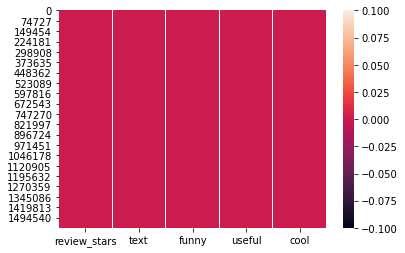

In [ ]:
df
sns.heatmap(df[df.columns].isnull())

# Ing de variables

In [ ]:
df['review_stars'].value_counts()

5    579527
4    466599
3    222719
1    159811
2    140608
Name: review_stars, dtype: int64

### Varaibles Sentiment

In [ ]:
# sentiment

# 4 o 5 : positivo
# 3 : neutro
# 1 o 2 : negativo 


def sentiment(n):
    if n >= 4:
        return 1 
    if n <= 2 :
        return 0
    if n == 3 :
        return 2


In [ ]:
df['sentiment'] = df['review_stars'].apply(sentiment)
df.head()

,review_stars,text,funny,useful,cool,sentiment
0,5,dr. goldberg offers everything i look for in a...,0,2,2,1
1,2,"Unfortunately, the frustration of being Dr. Go...",0,2,2,0
2,4,Dr. Goldberg has been my doctor for years and ...,0,1,1,1
3,4,Been going to Dr. Goldberg for over 10 years. ...,0,0,0,1
4,4,Got a letter in the mail last week that said D...,0,2,2,1


### Variables = Numero de palabras, numero de mayusculas, numero de caracteres esp

In [ ]:

df['Num_palabras'] = [len(review.split()) for review in df['text']]

df['Num_de_mayusculas'] = [sum(char.isupper() for char in review) \
                              for review in df['text']]                           

df['Num_caracteres_esp'] = [sum(char in string.punctuation for char in review) \
                            for review in df['text']]  

In [ ]:
df

,review_stars,text,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp
0,5,dr. goldberg offers everything i look for in a...,0,2,2,1,93,0,18
1,2,"Unfortunately, the frustration of being Dr. Go...",0,2,2,0,115,19,22
2,4,Dr. Goldberg has been my doctor for years and ...,0,1,1,1,55,10,10
3,4,Been going to Dr. Goldberg for over 10 years. ...,0,0,0,1,97,18,13
4,4,Got a letter in the mail last week that said D...,0,2,2,1,53,10,4
...,...,...,...,...,...,...,...,...,...
1569259,1,Looks like all of the good reviews have gone t...,1,2,2,0,81,41,13
1569260,5,Ryan Rocks! I called him this morning for some...,0,0,0,1,137,15,17
1569261,5,I was able to once again rely on Yelp to provi...,0,0,0,1,71,11,8
1569262,1,I have been using this company for 11 months. ...,2,8,8,0,244,141,50


# Limpieza del texto

### Normalizacion 

In [ ]:

def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df


In [ ]:
data_clean = clean_text(df, 'text', 'text_clean')
data_clean.head()

,review_stars,text,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_clean
0,5,dr. goldberg offers everything i look for in a...,0,2,2,1,93,0,18,dr goldberg offers everything i look for in a ...
1,2,"Unfortunately, the frustration of being Dr. Go...",0,2,2,0,115,19,22,unfortunately the frustration of being dr gold...
2,4,Dr. Goldberg has been my doctor for years and ...,0,1,1,1,55,10,10,dr goldberg has been my doctor for years and i...
3,4,Been going to Dr. Goldberg for over 10 years. ...,0,0,0,1,97,18,13,been going to dr goldberg for over years i th...
4,4,Got a letter in the mail last week that said D...,0,2,2,1,53,10,4,got a letter in the mail last week that said d...


In [ ]:
del df

### Stop words

In [ ]:
stopwords = []

In [ ]:
with open('listfile.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        stopwords.append(currentPlace)

In [ ]:


data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
data_clean.head()

,review_stars,text,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_clean
0,5,dr. goldberg offers everything i look for in a...,0,2,2,1,93,0,18,dr goldberg offers everything look general pra...
1,2,"Unfortunately, the frustration of being Dr. Go...",0,2,2,0,115,19,22,unfortunately frustration dr goldbergs patient...
2,4,Dr. Goldberg has been my doctor for years and ...,0,1,1,1,55,10,10,dr goldberg doctor years like ive found office...
3,4,Been going to Dr. Goldberg for over 10 years. ...,0,0,0,1,97,18,13,going dr goldberg years think one st patients ...
4,4,Got a letter in the mail last week that said D...,0,2,2,1,53,10,4,got letter mail last week said dr goldberg mov...


In [ ]:
data_clean= data_clean.drop('text', axis = 1)

In [ ]:
data_clean.to_csv('data_clean.csv')

In [ ]:
ls

drive/  sample_data/


### Tokenizado

In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data_clean

,Unnamed: 0,review_stars,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_clean
0,0,5,0,2,2,1,93,0,18,dr goldberg offers everything look general pra...
1,1,2,0,2,2,0,115,19,22,unfortunately frustration dr goldbergs patient...
2,2,4,0,1,1,1,55,10,10,dr goldberg doctor years like ive found office...
3,3,4,0,0,0,1,97,18,13,going dr goldberg years think one st patients ...
4,4,4,0,2,2,1,53,10,4,got letter mail last week said dr goldberg mov...
...,...,...,...,...,...,...,...,...,...,...
251267,251267,4,1,1,1,1,209,20,32,many times first review surprisingly review ba...
251268,251268,5,0,1,1,1,40,6,7,really dig place came fish chips great also go...
251269,251269,3,0,1,1,2,61,19,14,bop monday night tradition great atmosphere am...
251270,251270,5,0,0,0,1,77,11,11,town wedding came lunch ordered fish chips cam...


In [ ]:
data_clean = pd.read_csv('data_clean.csv')

In [ ]:


data_clean["text_clean"] = data_clean["text_clean"].astype(str)
data_clean.dtypes

Unnamed: 0             int64
review_stars           int64
funny                  int64
useful                 int64
cool                   int64
sentiment              int64
Num_palabras           int64
Num_de_mayusculas      int64
Num_caracteres_esp     int64
text_clean            object
dtype: object

In [ ]:

data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x: word_tokenize(x))
data_clean.head()

,Unnamed: 0,review_stars,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_clean,text_tokens
0,0,5,0,2,2,1,93,0,18,dr goldberg offers everything look general pra...,"[dr, goldberg, offers, everything, look, gener..."
1,1,2,0,2,2,0,115,19,22,unfortunately frustration dr goldbergs patient...,"[unfortunately, frustration, dr, goldbergs, pa..."
2,2,4,0,1,1,1,55,10,10,dr goldberg doctor years like ive found office...,"[dr, goldberg, doctor, years, like, ive, found..."
3,3,4,0,0,0,1,97,18,13,going dr goldberg years think one st patients ...,"[going, dr, goldberg, years, think, one, st, p..."
4,4,4,0,2,2,1,53,10,4,got letter mail last week said dr goldberg mov...,"[got, letter, mail, last, week, said, dr, gold..."


In [ ]:
data_clean.drop('text_clean', axis=1)

,Unnamed: 0,review_stars,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_tokens
0,0,5,0,2,2,1,93,0,18,"[dr, goldberg, offers, everything, look, gener..."
1,1,2,0,2,2,0,115,19,22,"[unfortunately, frustration, dr, goldbergs, pa..."
2,2,4,0,1,1,1,55,10,10,"[dr, goldberg, doctor, years, like, ive, found..."
3,3,4,0,0,0,1,97,18,13,"[going, dr, goldberg, years, think, one, st, p..."
4,4,4,0,2,2,1,53,10,4,"[got, letter, mail, last, week, said, dr, gold..."
...,...,...,...,...,...,...,...,...,...,...
251267,251267,4,1,1,1,1,209,20,32,"[many, times, first, review, surprisingly, rev..."
251268,251268,5,0,1,1,1,40,6,7,"[really, dig, place, came, fish, chips, great,..."
251269,251269,3,0,1,1,2,61,19,14,"[bop, monday, night, tradition, great, atmosph..."
251270,251270,5,0,0,0,1,77,11,11,"[town, wedding, came, lunch, ordered, fish, ch..."


### Stemming 

In [ ]:
from nltk.stem import PorterStemmer 

In [ ]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text


In [ ]:
data_clean['text_tokens_stem'] = data_clean['text_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head()

,Unnamed: 0,review_stars,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_clean,text_tokens,text_tokens_stem
0,0,5,0,2,2,1,93,0,18,dr goldberg offers everything look general pra...,"[dr, goldberg, offers, everything, look, gener...","[dr, goldberg, offer, everyth, look, gener, pr..."
1,1,2,0,2,2,0,115,19,22,unfortunately frustration dr goldbergs patient...,"[unfortunately, frustration, dr, goldbergs, pa...","[unfortun, frustrat, dr, goldberg, patient, re..."
2,2,4,0,1,1,1,55,10,10,dr goldberg doctor years like ive found office...,"[dr, goldberg, doctor, years, like, ive, found...","[dr, goldberg, doctor, year, like, ive, found,..."
3,3,4,0,0,0,1,97,18,13,going dr goldberg years think one st patients ...,"[going, dr, goldberg, years, think, one, st, p...","[go, dr, goldberg, year, think, one, st, patie..."
4,4,4,0,2,2,1,53,10,4,got letter mail last week said dr goldberg mov...,"[got, letter, mail, last, week, said, dr, gold...","[got, letter, mail, last, week, said, dr, gold..."


# Lemmatization

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
    
data_clean['text_tokens_lemma'] = data_clean['text_tokens'].apply(lambda x: word_lemmatizer(x))
data_clean.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Unnamed: 0,review_stars,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_clean,text_tokens,text_tokens_stem,text_tokens_lemma
0,0,5,0,2,2,1,93,0,18,dr goldberg offers everything look general pra...,"[dr, goldberg, offers, everything, look, gener...","[dr, goldberg, offer, everyth, look, gener, pr...","[dr, goldberg, offer, everything, look, genera..."
1,1,2,0,2,2,0,115,19,22,unfortunately frustration dr goldbergs patient...,"[unfortunately, frustration, dr, goldbergs, pa...","[unfortun, frustrat, dr, goldberg, patient, re...","[unfortunately, frustration, dr, goldberg, pat..."
2,2,4,0,1,1,1,55,10,10,dr goldberg doctor years like ive found office...,"[dr, goldberg, doctor, years, like, ive, found...","[dr, goldberg, doctor, year, like, ive, found,...","[dr, goldberg, doctor, year, like, ive, found,..."
3,3,4,0,0,0,1,97,18,13,going dr goldberg years think one st patients ...,"[going, dr, goldberg, years, think, one, st, p...","[go, dr, goldberg, year, think, one, st, patie...","[going, dr, goldberg, year, think, one, st, pa..."
4,4,4,0,2,2,1,53,10,4,got letter mail last week said dr goldberg mov...,"[got, letter, mail, last, week, said, dr, gold...","[got, letter, mail, last, week, said, dr, gold...","[got, letter, mail, last, week, said, dr, gold..."


In [ ]:
data_clean = data_clean.drop(['text_clean',	'text_tokens',	'text_tokens_stem'], axis = 1)

In [ ]:
y = data_clean['sentiment']
X = data_clean['text_tokens_lemma']

### Exploracion de datos 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

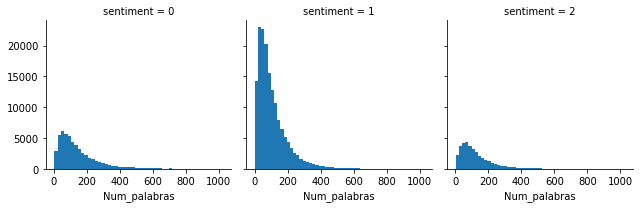

In [14]:
g = sns.FacetGrid(data=data, col='sentiment')
g.map(plt.hist, 'Num_palabras', bins=50)
plt.show()

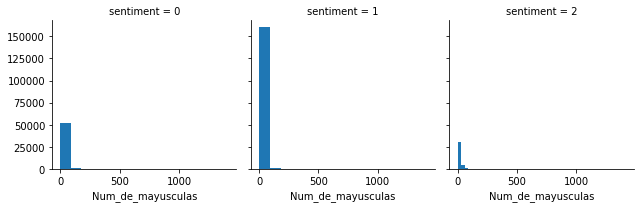

In [19]:
g = sns.FacetGrid(data=data, col='sentiment')
g.map(plt.hist, 'Num_de_mayusculas', bins=15)
plt.show()

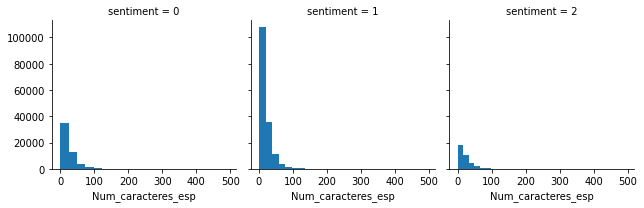

In [16]:
g = sns.FacetGrid(data=data, col='sentiment')
g.map(plt.hist, 'Num_caracteres_esp', bins=20)
plt.show()

In [ ]:
### Las columnas nª de mayus, caracteres espciales y long del texto no aportan informacion para la clasificacion

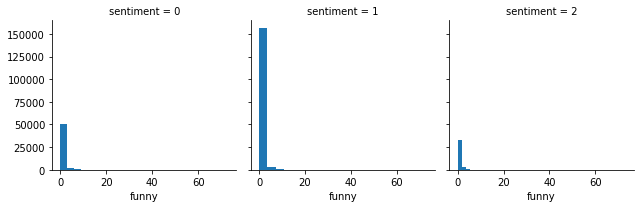

In [55]:
g = sns.FacetGrid(data=data, col='sentiment')
g.map(plt.hist, 'funny', bins=20)
plt.show()

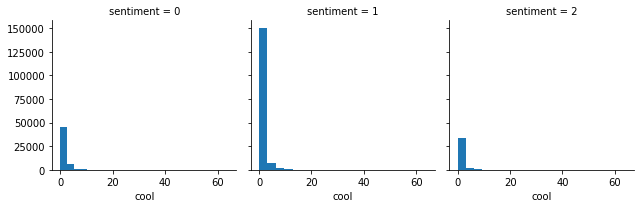

In [56]:
g = sns.FacetGrid(data=data, col='sentiment')
g.map(plt.hist, 'cool', bins=20)
plt.show()

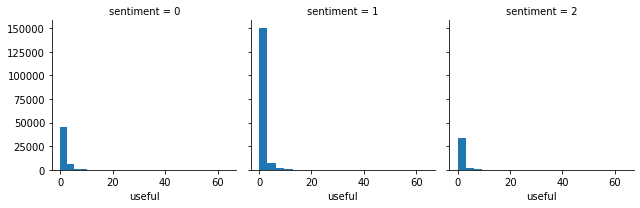

In [57]:
g = sns.FacetGrid(data=data, col='sentiment')
g.map(plt.hist, 'useful', bins=20)
plt.show()

In [58]:
### Las col funny, cool y usefull tampoco aportan mucha info para la clasificacion 

In [26]:
from wordcloud import WordCloud, STOPWORDS

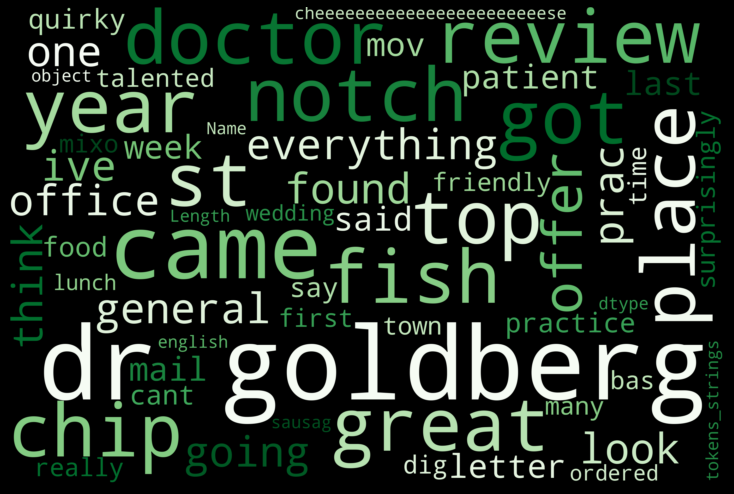

In [53]:
## WORD CLOUD RESEÑAS POSITIVAS

data1 = data.loc[data['sentiment'] == 1, 'tokens_strings']
                     
          

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap="Greens",
    stopwords = STOPWORDS).generate(str(data1))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

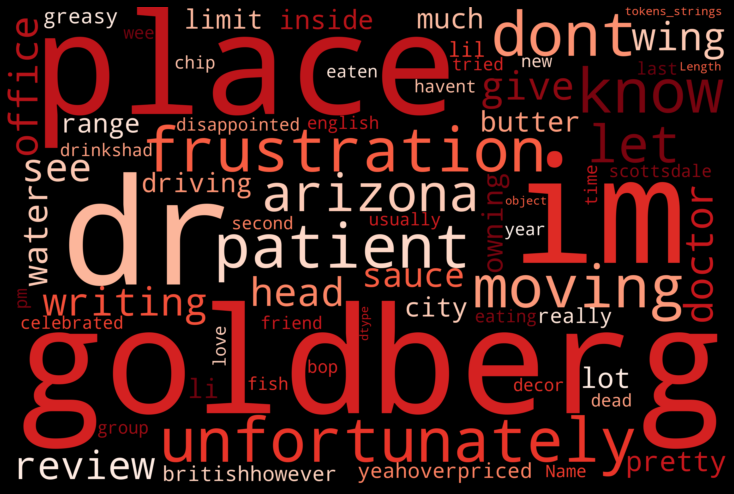

In [52]:
## WORD CLOUD RESEÑAS NEGATIVAS

data2 = data.loc[data['sentiment'] == 0, 'tokens_strings']
                     
          

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap="Reds",
    stopwords = STOPWORDS).generate(str(data2))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

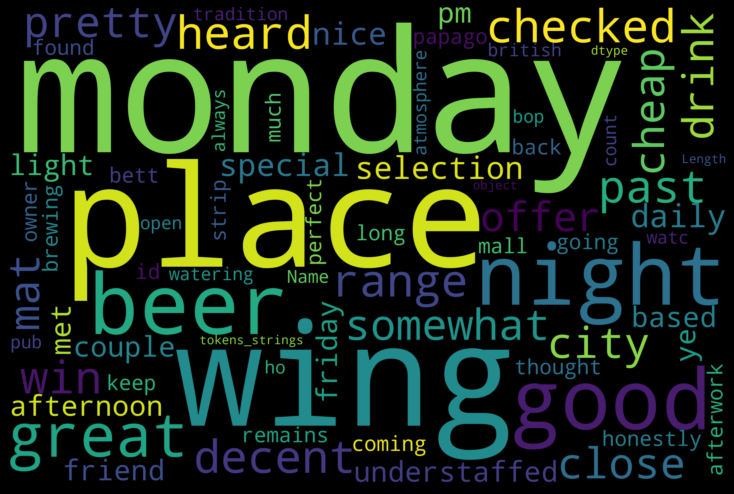

In [47]:
## WORD CLOUD RESEÑAS neutras

data3 = data.loc[data['sentiment'] == 2, 'tokens_strings']
                     
          

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(data3))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

### VECTORIZACION

In [44]:
 # El primer paso es convertir las listas de tokens en la columna text_token en strings, para posteriormente poder vectorizar
    

data['tokens_strings'] = data['text_tokens_lemma'].apply(eval).apply(' '.join)

In [39]:
data

,Unnamed: 0,Unnamed: 0.1,review_stars,funny,useful,cool,sentiment,Num_palabras,Num_de_mayusculas,Num_caracteres_esp,text_tokens_lemma,tokens_strings
0,0,0,5,0,2,2,1,93,0,18,"['dr', 'goldberg', 'offer', 'everything', 'loo...",dr goldberg offer everything look general prac...
1,1,1,2,0,2,2,0,115,19,22,"['unfortunately', 'frustration', 'dr', 'goldbe...",unfortunately frustration dr goldberg patient ...
2,2,2,4,0,1,1,1,55,10,10,"['dr', 'goldberg', 'doctor', 'year', 'like', '...",dr goldberg doctor year like ive found office ...
3,3,3,4,0,0,0,1,97,18,13,"['going', 'dr', 'goldberg', 'year', 'think', '...",going dr goldberg year think one st patient st...
4,4,4,4,0,2,2,1,53,10,4,"['got', 'letter', 'mail', 'last', 'week', 'sai...",got letter mail last week said dr goldberg mov...
...,...,...,...,...,...,...,...,...,...,...,...,...
251267,251267,251267,4,1,1,1,1,209,20,32,"['many', 'time', 'first', 'review', 'surprisin...",many time first review surprisingly review bas...
251268,251268,251268,5,0,1,1,1,40,6,7,"['really', 'dig', 'place', 'came', 'fish', 'ch...",really dig place came fish chip great also got...
251269,251269,251269,3,0,1,1,2,61,19,14,"['bop', 'monday', 'night', 'tradition', 'great...",bop monday night tradition great atmosphere am...
251270,251270,251270,5,0,0,0,1,77,11,11,"['town', 'wedding', 'came', 'lunch', 'ordered'...",town wedding came lunch ordered fish chip came...


In [59]:
## Antes de vectorizar dividimos el df en train y test

In [60]:
data= data.drop(['text_tokens_lemma', 'Unnamed: 0','Unnamed: 0.1','review_stars'], axis = 1 )
y = data['sentiment']
X = data['tokens_strings']

In [61]:
X

0         dr goldberg offer everything look general prac...
1         unfortunately frustration dr goldberg patient ...
2         dr goldberg doctor year like ive found office ...
3         going dr goldberg year think one st patient st...
4         got letter mail last week said dr goldberg mov...
                                ...                        
251267    many time first review surprisingly review bas...
251268    really dig place came fish chip great also got...
251269    bop monday night tradition great atmosphere am...
251270    town wedding came lunch ordered fish chip came...
251271    cheeeeeeeeeeeeeeeeeeeeeeese get english sausag...
Name: tokens_strings, Length: 251272, dtype: object

In [62]:
# SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [64]:
# fit and transform X_train
X_train_dtm = vect.fit_transform(X_train)

In [65]:
# only transform X_test
X_test_dtm = vect.transform(X_test)

In [66]:
# examine the shapes
print(X_train_dtm.shape)
print(X_test_dtm.shape)

(188454, 243367)
(62818, 243367)


### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
rf = RandomForestClassifier(criterion='gini')
rf.fit(X_train_dtm, y_train)

RandomForestClassifier()

In [69]:
pred_rf = rf.predict(X_test_dtm)

In [111]:
pred_rf

array([1, 1, 0, ..., 1, 1, 1])

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
print("Confusion Matrix\n",confusion_matrix(y_test, pred_rf))
print("\n")
print("Classification report\n",classification_report(y_test, pred_rf))

Confusion Matrix
 [[ 6938  6381    70]
 [  343 39811    33]
 [  650  8461   131]]


Classification report
               precision    recall  f1-score   support

           0       0.87      0.52      0.65     13389
           1       0.73      0.99      0.84     40187
           2       0.56      0.01      0.03      9242

    accuracy                           0.75     62818
   macro avg       0.72      0.51      0.51     62818
weighted avg       0.73      0.75      0.68     62818

